# Imports 

### Iteration 3: NB_multinomial with word embeddings

In [1]:

import numpy as np
import pandas as pd
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from datasets import load_dataset
import time
from datetime import datetime
import json
import base64
import struct
import warnings
import torch
import os
warnings.filterwarnings('ignore')

c:\Users\Lucas Tay\OneDrive - AIA Singapore Private Limited (1)\Desktop\AI project\WELFake_AI_Project\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Define device for torch
use_cuda = True
print("CUDA is available:", torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")

CUDA is available: False


In [3]:
# Global variables
EMBEDDING_COLUMN_NAMES = ["tfidf_embedding","bow_embedding","w2v_embedding", "roberta_embedding"]

In [4]:
# Function to fix and scale dataset
def fix_and_scale_dataset(df, embedding_column_name):
    seed = 45
    y = df["label"]
    x = df[embedding_column_name]
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=seed)
    
    x_train_fixed = np.stack(x_train)  
    x_test_fixed = np.stack(x_test)
    
    # For Multinomial NB, ensure features are non-negative
    # Option 1: Just ensure no negative values (simple approach)
    x_train_fixed = np.maximum(0, x_train_fixed)
    x_test_fixed = np.maximum(0, x_test_fixed)
    
    # Option 2: Use MinMaxScaler but ensure range is [0, 1] not [-1, 1]
    scaler = MinMaxScaler(feature_range=(0, 1))
    x_train_scaled = scaler.fit_transform(x_train_fixed)
    x_test_scaled = scaler.transform(x_test_fixed)
    
    # Remove NaN values
    x_train_scaled = np.nan_to_num(x_train_scaled, nan=0.0)
    x_test_scaled = np.nan_to_num(x_test_scaled, nan=0.0)
    
    return x_train_scaled, x_test_scaled, y_train, y_test
    

In [5]:
# Function to decode the custom embedding format
def decode_embedding(encoded_str):
    """
    Decode the custom embedding format to a numeric vector.
    Example input: 'AQAAAAAAAABAAAAAAAAAAQAAAAAAAAEAAAAAAAAAAQA...'
    """
    try:
        # First try base64 decoding
        try:
            # Try standard base64
            decoded = base64.b64decode(encoded_str)
        except:
            # If that fails, try to pad the string and decode
            padding_needed = len(encoded_str) % 4
            if padding_needed:
                encoded_str += '=' * (4 - padding_needed)
            decoded = base64.b64decode(encoded_str)
        
        # Try to interpret as floats (8 bytes per float)
        if len(decoded) % 8 == 0:
            num_floats = len(decoded) // 8
            return np.array(struct.unpack(f'>{num_floats}d', decoded))
        
        # Try to interpret as floats (4 bytes per float)
        if len(decoded) % 4 == 0:
            num_floats = len(decoded) // 4
            return np.array(struct.unpack(f'>{num_floats}f', decoded))
            
        # If the above fail, try to interpret as a sequence of bytes
        return np.frombuffer(decoded, dtype=np.uint8)
    
    except Exception as e:
        print(f"Error decoding embedding: {e}")
        # As a fallback, convert each character to its ASCII value
        return np.array([ord(c) for c in encoded_str])

### Load Training Dataset

Load the training dataset with CBOW-W2V embeddings

In [6]:
dataset = load_dataset("Paulozs/WELFake_embeddings")
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['title', 'text', 'label', 'roberta_embedding', 'bow_embedding', 'tfidf_embedding', 'w2v_embedding'],
        num_rows: 62592
    })
})


### Split Dataset

In [7]:
#convert dataset to pandas for easier implementation with sklearn

df = dataset["train"].to_pandas()
display(df)

,title,text,label,roberta_embedding,bow_embedding,tfidf_embedding,w2v_embedding
0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,"[0.77837825, -1.3829339, 0.21932077, -0.037815...","[12.751228183014527, -8.760484977091297, -2.46...","[0.3186029772902578, -0.1094107173745029, 0.10...","[0.005737772, 0.051631283, 0.039275542, 0.0679..."
1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,"[-3.4394891, -1.1532453, -0.57524085, -0.29689...","[0.1540906344076637, -0.06480693954115654, -0....","[0.07578831287738759, -0.015240886953002832, 0...","[0.014999917, 0.057231702, 0.05448833, 0.10918..."
2,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"[0.61816597, 0.10020125, -0.627897, -0.1652965...","[11.144724982986332, -6.606145662614691, -0.79...","[0.3980779078413261, -0.15109853445516602, 0.0...","[0.04940245, 0.03809506, 0.030635785, 0.096523..."
3,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,"[0.6582862, 0.40051103, -0.35593724, 0.6198630...","[2.6159286882160537, -1.72675977752399, -0.519...","[0.21115011222058097, -0.14267633316979805, -0...","[-0.022517398, 0.08829837, 0.06998471, 0.05531..."
4,About Time! Christian Group Sues Amazon and SP...,All we can say on this one is it s about time ...,1,"[0.51393855, 0.6349008, 1.0849333, 0.33767414,...","[1.9346475297557924, -1.1505992523835311, -0.7...","[0.1945931561404842, -0.1142489399938969, 0.00...","[0.031655375, 0.018008867, 0.039424133, 0.0783..."
...,...,...,...,...,...,...,...
62587,WIKILEAKS EMAIL SHOWS CLINTON FOUNDATION FUNDS...,An email released by WikiLeaks on Sunday appea...,1,"[-0.74468505, 0.1229167, 1.3666742, 0.07904005...","[3.622973638522903, -0.54198912841281, -1.4584...","[0.23084806769137872, 0.09422806198766091, 0.3...","[-0.00035927512, 0.04827896, -0.027950248, 0.0..."
62588,Russians steal research on Trump in hack of U....,WASHINGTON (Reuters) - Hackers believed to be ...,0,"[0.5316571, 0.9854491, -0.6684599, -0.01448869...","[17.799926846744107, 1.1087862440581235, 1.350...","[0.4787758131172253, 0.003986352099122974, -0....","[-0.020597927, 0.025891328, 0.0079015875, 0.06..."
62589,WATCH: Giuliani Demands That Democrats Apolog...,"You know, because in fantasyland Republicans n...",1,"[0.6461022, -1.1085404, 0.13549614, -0.3637871...","[16.499211522306364, 13.110890533481918, -1.99...","[0.45380863043849157, 0.3371814687589905, -0.0...","[0.026168875, 0.059571818, 0.025066013, 0.0854..."
62590,Migrants Refuse To Leave Train At Refugee Camp...,Migrants Refuse To Leave Train At Refugee Camp...,0,"[0.5340885, -0.03433156, -0.3962021, 0.1179680...","[5.264526534165657, -3.8853342501017916, -0.87...","[0.290404249417728, -0.21906293500944446, -0.0...","[0.009088822, 0.061462272, 0.026323821, 0.0745..."


# TF-IDF Embedding

In [8]:
# run the loading function
seed = 45
x_train_tfidf, x_test_tfidf, y_train_tfidf, y_test_tfidf = fix_and_scale_dataset(df, "tfidf_embedding")

In [9]:
nb = MultinomialNB()

## Hyper Parameter Tuning

In [10]:
# RandomizedSearchCV - includes cross-validation
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

# Define the parameter distribution for MultinomialNB
param_dist = {'alpha': uniform(0.001, 10.0)}

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(nb, 
                                 param_distributions=param_dist, 
                                 n_iter=20, 
                                 cv=5,
                                 n_jobs=-1,
                                 random_state=seed)

# Fit the random search object to the data
rand_search.fit(x_train_tfidf, y_train_tfidf)


RandomizedSearchCV(cv=5, estimator=MultinomialNB(), n_iter=20, n_jobs=-1,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x000001A032B47DC0>},
                   random_state=45)

In [11]:
# Create a variable for the best model
tfidf_nb_multinomial = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'alpha': np.float64(0.4862200090644587)}


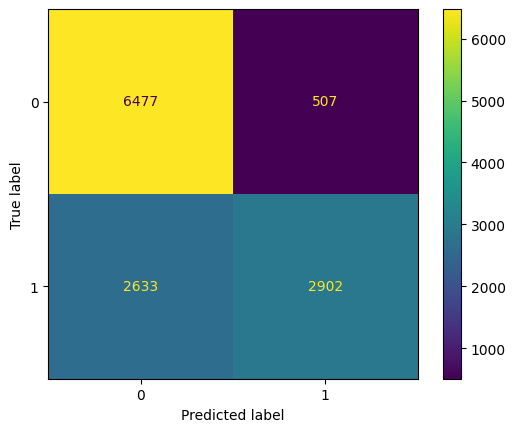

In [12]:
# Generate predictions with the best model
y_pred = tfidf_nb_multinomial.predict(x_test_tfidf)

# Create the confusion matrix
cm = confusion_matrix(y_test_tfidf, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [13]:
accuracy = accuracy_score(y_test_tfidf, y_pred)
precision = precision_score(y_test_tfidf, y_pred, average='binary') 
recall = recall_score(y_test_tfidf, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7491812445083473
Precision: 0.851276034027574
Recall: 0.5242999096657633


# BOW Embedding

In [14]:
x = df["bow_embedding"]
x_train_bow, x_test_bow, y_train_bow, y_test_bow = fix_and_scale_dataset(df, "bow_embedding")
nb = MultinomialNB()

In [15]:
rand_search.fit(x_train_bow, y_train_bow)

# Create a variable for the best model
bow_nb_multinomial = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'alpha': np.float64(0.4862200090644587)}


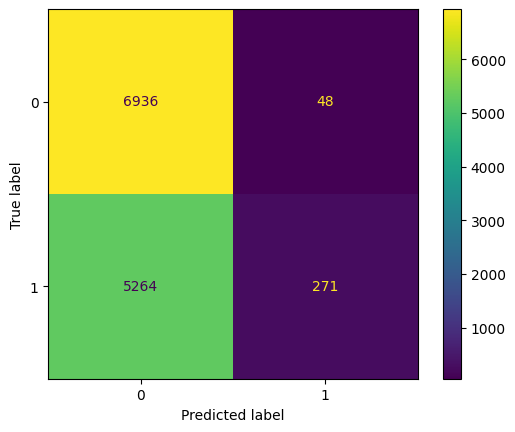

In [16]:
y_pred = bow_nb_multinomial.predict(x_test_bow)

# Create the confusion matrix
cm = confusion_matrix(y_test_bow, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [17]:
accuracy = accuracy_score(y_test_bow, y_pred)
precision = precision_score(y_test_bow, y_pred, average='binary') 
recall = recall_score(y_test_bow, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5756849588625289
Precision: 0.8495297805642633
Recall: 0.04896115627822945


## CBOW-W2V

In [18]:
x = df["w2v_embedding"]
x_train_w2v, x_test_w2v, y_train_w2v, y_test_w2v = fix_and_scale_dataset(df, "w2v_embedding")
nb = MultinomialNB()

In [19]:
rand_search.fit(x_train_w2v, y_train_w2v)

# Create a variable for the best model
w2v_nb_multinomial = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'alpha': np.float64(0.4862200090644587)}


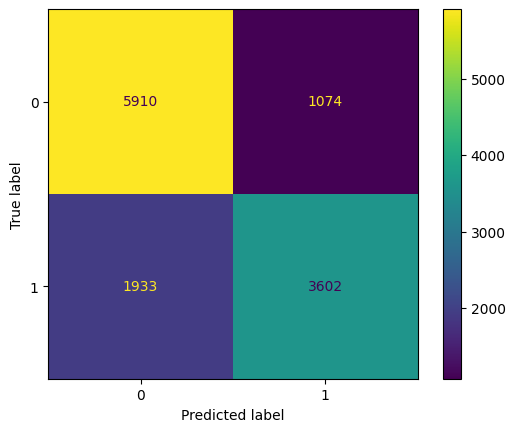

In [20]:
y_pred = w2v_nb_multinomial.predict(x_test_w2v)

# Create the confusion matrix
cm = confusion_matrix(y_test_w2v, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [21]:
accuracy = accuracy_score(y_test_w2v, y_pred)
precision = precision_score(y_test_w2v, y_pred, average='binary') 
recall = recall_score(y_test_w2v, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7598050962536944
Precision: 0.7703165098374679
Recall: 0.6507678410117435


## Roberta

In [22]:
x = df["roberta_embedding"]
x_train_roberta, x_test_roberta, y_train_roberta, y_test_roberta = fix_and_scale_dataset(df, "roberta_embedding")
nb = MultinomialNB()

In [23]:
rand_search.fit(x_train_roberta, y_train_roberta)

# Create a variable for the best model
roberta_nb_multinomial = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'alpha': np.float64(0.773895660791727)}


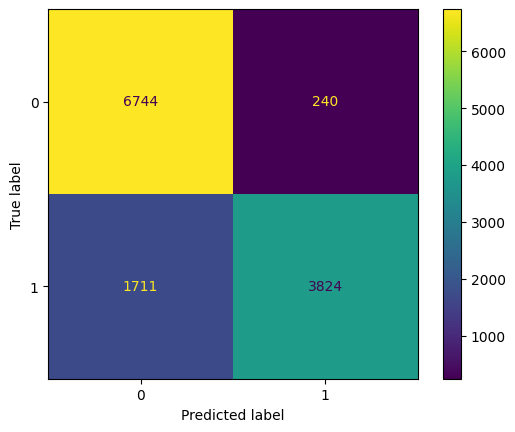

In [24]:
y_pred = roberta_nb_multinomial.predict(x_test_roberta)

# Create the confusion matrix
cm = confusion_matrix(y_test_roberta, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot()

In [25]:
accuracy = accuracy_score(y_test_roberta, y_pred)
precision = precision_score(y_test_roberta, y_pred, average='binary') 
recall = recall_score(y_test_roberta, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8441568815400591
Precision: 0.9409448818897638
Recall: 0.6908762420957543


## Results on test set

In [26]:
test_dataset = load_dataset("lelexuanzz/Gossipcop_Politifact_Test")
print(test_dataset)

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'tfidf_embedding', 'bow_embedding', 'w2v_embedding', 'roberta_embedding'],
        num_rows: 6900
    })
})


In [27]:
test_df = test_dataset["train"].to_pandas()
display(test_df)


,text,label,tfidf_embedding,bow_embedding,w2v_embedding,roberta_embedding
0,The media reported on “5 TikTok dances you can...,0,"[0.32230591024075883, -0.028311949900530733, 0...","[4.111553694916485, -1.4091154149948346, -2.22...","[0.023112578, 0.004341462, -0.028385904, 0.039...","[-1.7613875, -0.29602507, 1.0549823, 0.4420643..."
1,"""Over 240,000 'unverified' ballots have alread...",0,"[0.3085783060828623, 0.11941719268786223, 0.04...","[15.340171294779958, 0.6782201913070947, -3.95...","[0.013536842, 0.009806181, 0.0037024287, 0.046...","[0.5113651, -0.5632596, -0.08679409, 0.0578204..."
2,"Says ""Ron Johnson is making excuses for rioter...",1,"[0.42330438481857957, 0.07862740950249068, 0.0...","[17.579511089264834, -3.370470538008803, -6.03...","[0.023063188, 0.059482925, 0.01734151, 0.06674...","[0.4061544, 0.033350937, -0.30923274, -0.04415..."
3,“We have seen over the last 10 years ... under...,0,"[0.3235193218432473, 0.1435034790001879, -0.01...","[13.623137823124184, 2.594215458815296, 1.1975...","[-0.03447485, 0.012470036, 0.040506534, 0.1266...","[0.74233645, -0.8022974, 0.30516905, -0.150992..."
4,“I don’t get involved in the hiring and firing...,0,"[0.21714023268741092, -0.013357531354942328, 0...","[11.715673205868814, -3.8977639951627094, -0.5...","[-0.039161813, 0.050845865, 0.045167223, -0.00...","[0.4902299, -0.04709744, -0.11096978, -0.33383..."
...,...,...,...,...,...,...
6895,Wedding Album: Dancing with the Stars Pro Lind...,0,"[0.14163919484467705, -0.1871535330863532, -0....","[0.5081918596591085, -0.4770132598925509, 0.04...","[0.007478841, 0.028465271, 0.01225586, 0.05277...","[-4.3445463, -0.82720375, -0.76975673, 0.55827..."
6896,WATCH: Sneak Peek: Arizona's Furious Alex Atta...,0,"[0.10089287837516506, -0.15370171061200275, -0...","[0.34453471754679216, -0.49345817220335975, 0....","[0.03495687, 0.08366224, 0.03197157, 0.0962388...","[-3.484783, -0.13741834, -0.2212331, 0.3501901..."
6897,Mary Kay Letourneau 'Hopeful' She Can Fix Marr...,0,"[0.30012685395650657, -0.2629061112392972, -0....","[5.587042723074881, -3.018912737323734, -0.696...","[0.0066373795, 0.04132683, 0.008552303, 0.0507...","[0.060427, 0.93066996, -0.5383188, -0.11787002..."
6898,Charlize Theron still upset Aeon Flux didn’t w...,0,"[0.18598375894521132, -0.26601918530104635, -0...","[1.8348212505816643, -2.5021137033474385, 0.45...","[0.032494266, 0.038722403, -0.01410776, 0.0764...","[0.29304072, 1.2304765, -0.0635877, 0.6557827,..."


### TF-IDF

In [28]:
y_test_set = test_df["label"]
x_test_set = test_df["tfidf_embedding"]
x_test_set_fixed = np.stack(x_test_set)

# Ensure no negative values
x_test_set_fixed = np.maximum(0, x_test_set_fixed)
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit the scaler on the training data
scaler.fit(x_train_tfidf)

# Scale the test set using the same scaler used for training
x_test_set_scaled = scaler.transform(x_test_set_fixed)

print(x_test_set_scaled.shape)

(6900, 300)


In [29]:
# Generate predictions
y_test_pred = tfidf_nb_multinomial.predict(x_test_set_scaled)

In [30]:
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred,average='binary')
recall = recall_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.633768115942029
Precision: 0.14022140221402213
Recall: 0.016295025728987993


### BOW

In [31]:
y_test_set = test_df["label"]
x_test_set = test_df["bow_embedding"]
x_test_set_fixed = np.stack(x_test_set)

# Ensure no negative values
x_test_set_fixed = np.maximum(0, x_test_set_fixed)
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit the scaler on the training data
scaler.fit(x_train_bow)

# Scale the test set using the same scaler used for training
x_test_set_scaled = scaler.transform(x_test_set_fixed)

print(x_test_set_scaled.shape)

(6900, 300)


In [32]:
# Generate predictions
y_test_pred = tfidf_nb_multinomial.predict(x_test_set_scaled)

In [33]:
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred,average='binary')
recall = recall_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6521739130434783
Precision: 0.44801223241590216
Recall: 0.12564322469982847


### CBOW-W2V

In [34]:
y_test_set = test_df["label"]
x_test_set = test_df["w2v_embedding"]
x_test_set_fixed = np.stack(x_test_set)

# Ensure no negative values
x_test_set_fixed = np.maximum(0, x_test_set_fixed)
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit the scaler on the training data
scaler.fit(x_train_w2v)

# Scale the test set using the same scaler used for training
x_test_set_scaled = scaler.transform(x_test_set_fixed)

print(x_test_set_scaled.shape)

(6900, 300)


In [35]:
# Generate predictions
y_test_pred = tfidf_nb_multinomial.predict(x_test_set_scaled)

In [36]:
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred,average='binary')
recall = recall_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6620289855072464
Precision: 0.5
Recall: 0.0004288164665523156


### Roberta

In [37]:
y_test_set = test_df["label"]
x_test_set = test_df["roberta_embedding"]
x_test_set_fixed = np.stack(x_test_set)

# Ensure no negative values
x_test_set_fixed = np.maximum(0, x_test_set_fixed)
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit the scaler on the training data
scaler.fit(x_train_roberta)

# Scale the test set using the same scaler used for training
x_test_set_scaled = scaler.transform(x_test_set_fixed)

print(x_test_set_scaled.shape)

(6900, 300)


In [38]:
# Generate predictions
y_test_pred = tfidf_nb_multinomial.predict(x_test_set_scaled)

In [39]:
accuracy = accuracy_score(y_test_set, y_test_pred)
precision = precision_score(y_test_set, y_test_pred,average='binary')
recall = recall_score(y_test_set, y_test_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.4846376811594203
Precision: 0.1855087358684481
Recall: 0.15480274442538594


# Save Model

In [ ]:
import pickle

pickle.dump(tfidf_nb_multinomial, open("trained_models/iter3_nb_tfidf", 'wb'))
pickle.dump(bow_nb_multinomial, open("trained_models/iter3_nb_bow", 'wb'))
pickle.dump(w2v_nb_multinomial, open("trained_models/iter3_nb_w2v", 'wb'))
pickle.dump(roberta_nb_multinomial, open("trained_models/iter4_nb_roberta", 'wb'))

FileNotFoundError: [Errno 2] No such file or directory: 'models/iter3_nb_tfidf'